In [1]:
from google.colab import drive
drive .mount('/content/drive')


Mounted at /content/drive


In [2]:
import os

os.listdir("/content/drive/MyDrive")


['Getting started.pdf',
 'Book1.csv',
 'AlzheimersData.csv',
 'Colab Notebooks',
 'Churn_Modelling.csv',
 'customers-1000.csv',
 'Daisi_Williams_Academic_grades.pdf',
 'Daisi_Williams_Curriculum_Vitae.pdf',
 '6439.jpg',
 'send_Williams.zip',
 'UIQC Membership Form – DAISI WILLIAMS.gdoc',
 '2025-10',
 'Vids Exports',
 'Untitled video (2).gvid',
 'Untitled video (1).gvid',
 'Untitled video.gvid',
 'Daisi Williams_Hackathon_Solution.pdf',
 'merged_with_CM_5dp.csv',
 'samplequestions.pdf',
 'Experimental Lab 4 - Waldron.docx',
 'Daisi Williams SOP.pdf',
 'Determination_of_Plancks_Constant_by_Measurement_of_the_Photoelectric_Effect.pdf',
 'Personal Statement MSE.gdoc',
 'Personal Statement Physics.gdoc',
 'SOP phyiscs.gdoc',
 'SOP MSE.gdoc',
 'weather_cnn_rnn_model.h5',
 'class_names.json',
 'the uploads',
 'cleaned_merged_with_CM_5dp.csv']

In [3]:
import pandas as pd
import numpy as np

CSV_PATH = "/content/drive/MyDrive/merged_with_CM_5dp.csv"
df = pd.read_csv(CSV_PATH)

bad_rows = [4654, 21291]   # <-- pandas row indices (0-based)

df_clean = df.drop(index=bad_rows).reset_index(drop=True)

print("Original rows:", len(df))
print("Cleaned rows :", len(df_clean))
print("Dropped rows :", bad_rows)


Original rows: 21323
Cleaned rows : 21321
Dropped rows : [4654, 21291]


In [4]:
baseline_E1 = df_clean["E1-DFTB"].to_numpy(dtype=float)

print("E1-DFTB range after cleaning:",
      baseline_E1.min(), baseline_E1.max())

# Optional: confirm no huge outliers remain
print("Count E1-DFTB > 10:", np.sum(baseline_E1 > 10))


E1-DFTB range after cleaning: 0.0004 21011.0
Count E1-DFTB > 10: 25


In [5]:
# Rows with suspiciously large values
mask_large = df_clean["E1-DFTB"] >= 2.0

# Rows with near-zero values
mask_small = df_clean["E1-DFTB"] < 0.01

print("Count E1-DFTB >= 2.0:", mask_large.sum())
print("Count E1-DFTB < 0.01:", mask_small.sum())

df_clean.loc[mask_large | mask_small,
             ["gdb9_index", "E1-DFTB", "E1-CC2"]].head(10)


Count E1-DFTB >= 2.0: 25
Count E1-DFTB < 0.01: 4


,gdb9_index,E1-DFTB,E1-CC2
201,207,207.0,0.21334
1381,1421,1421.0,0.16026
1434,1474,1474.0,0.23437
1980,2036,2036.0,0.27893
2375,2434,2434.0,0.25141
2503,2564,2564.0,0.16484
2572,2633,2633.0,0.21365
3178,3239,3239.0,0.30893
3333,3394,3394.0,0.16587
3934,4012,4012.0,0.22477


In [6]:
mask_physical = (
    (df_clean["E1-DFTB"] >= 0.01) &
    (df_clean["E1-DFTB"] <= 2.0)
)

df_phys = df_clean.loc[mask_physical].reset_index(drop=True)

print("Rows before:", len(df_clean))
print("Rows after :", len(df_phys))
print("Dropped    :", len(df_clean) - len(df_phys))


Rows before: 21321
Rows after : 21292
Dropped    : 29


In [7]:
baseline_E1 = df_phys["E1-DFTB"].to_numpy(dtype=float)

print("E1-DFTB range after filtering:",
      baseline_E1.min(), baseline_E1.max())

print("Count E1-DFTB > 2.0:", (baseline_E1 > 2.0).sum())
print("Count E1-DFTB < 0.01:", (baseline_E1 < 0.01).sum())


E1-DFTB range after filtering: 0.01352 0.84876
Count E1-DFTB > 2.0: 0
Count E1-DFTB < 0.01: 0


In [8]:
cm_cols = [c for c in df_phys.columns if c.startswith("CM_")]

X = df_phys[cm_cols].to_numpy(dtype=float)
baseline_E1 = df_phys["E1-DFTB"].to_numpy(dtype=float)
target_E1   = df_phys["E1-CC2"].to_numpy(dtype=float)

dE1 = target_E1 - baseline_E1

print("X shape:", X.shape)
print("ΔE1 range:", dE1.min(), dE1.max())
print("ΔE1 mean ± std:", dE1.mean(), dE1.std())

assert np.isfinite(X).all()
assert np.isfinite(dE1).all()


X shape: (21292, 26)
ΔE1 range: -0.62257 0.30557999999999996
ΔE1 mean ± std: -0.015456138925417997 0.09605581848452671


In [9]:
import numpy as np
import pandas as pd

print("===== DATASET SANITY CHECK =====")

# -----------------------------
# 1. Shape & basic integrity
# -----------------------------
print("\n[1] Dataset shape")
print("Rows:", len(df_phys))
print("Columns:", df_phys.shape[1])

# -----------------------------
# 2. Required columns present
# -----------------------------
required_cols = ["E1-DFTB", "E1-CC2"]
cm_cols = [c for c in df_phys.columns if c.startswith("CM_")]

print("\n[2] Required columns check")
print("E1-DFTB present:", "E1-DFTB" in df_phys.columns)
print("E1-CC2 present :", "E1-CC2" in df_phys.columns)
print("Number of CM features:", len(cm_cols))

# -----------------------------
# 3. No NaN / Inf anywhere
# -----------------------------
print("\n[3] NaN / Inf check")
print("NaNs total:", df_phys.isna().sum().sum())
print("Infs total:",
      np.isinf(df_phys.select_dtypes(include=[float])).sum().sum())

# -----------------------------
# 4. Physical ranges (energies)
# -----------------------------
print("\n[4] Physical range check (Hartree)")
print("E1-DFTB range:",
      df_phys["E1-DFTB"].min(),
      df_phys["E1-DFTB"].max())

print("E1-CC2 range:",
      df_phys["E1-CC2"].min(),
      df_phys["E1-CC2"].max())

# -----------------------------
# 5. Δ-learning target check
# -----------------------------
dE1 = df_phys["E1-CC2"] - df_phys["E1-DFTB"]

print("\n[5] ΔE1 statistics")
print("ΔE1 min / max:", dE1.min(), dE1.max())
print("ΔE1 mean ± std:", dE1.mean(), dE1.std())

# -----------------------------
# 6. Feature matrix integrity
# -----------------------------
X = df_phys[cm_cols].to_numpy(dtype=float)

print("\n[6] Feature matrix check")
print("X shape:", X.shape)
print("X finite:", np.isfinite(X).all())

# -----------------------------
# 7. Correlation sanity (optional but powerful)
# -----------------------------
corr = np.corrcoef(df_phys["E1-DFTB"], df_phys["E1-CC2"])[0, 1]
print("\n[7] Baseline correlation")
print("Corr(E1-DFTB, E1-CC2):", corr)

print("\n===== SANITY CHECK PASSED =====")


===== DATASET SANITY CHECK =====

[1] Dataset shape
Rows: 21292
Columns: 35

[2] Required columns check
E1-DFTB present: True
E1-CC2 present : True
Number of CM features: 26

[3] NaN / Inf check
NaNs total: 0
Infs total: 0

[4] Physical range check (Hartree)
E1-DFTB range: 0.01352 0.84876
E1-CC2 range: 0.06957 0.51384

[5] ΔE1 statistics
ΔE1 min / max: -0.62257 0.30557999999999996
ΔE1 mean ± std: -0.015456138925417997 0.09605807424260773

[6] Feature matrix check
X shape: (21292, 26)
X finite: True

[7] Baseline correlation
Corr(E1-DFTB, E1-CC2): 0.09016857080034928

===== SANITY CHECK PASSED =====


In [10]:
DRIVE_OUT = "/content/drive/MyDrive/cleaned_merged_with_CM_5dp.csv"
df_phys.to_csv(DRIVE_OUT, index=False)

print("Saved to Google Drive at:", DRIVE_OUT)


Saved to Google Drive at: /content/drive/MyDrive/cleaned_merged_with_CM_5dp.csv


In [11]:
import pandas as pd

CSV_PATH = "/content/drive/MyDrive/cleaned_merged_with_CM_5dp.csv"
df = pd.read_csv(CSV_PATH)


In [12]:
cm_cols = [c for c in df.columns if c.startswith("CM_")]
X = df[cm_cols].to_numpy(dtype=float)

baseline_E1 = df["E1-DFTB"].to_numpy(dtype=float)
target_E1   = df["E1-CC2"].to_numpy(dtype=float)
dE1 = target_E1 - baseline_E1


In [13]:
print("Rows:", len(df))
print("E1-DFTB range:", df["E1-DFTB"].min(), df["E1-DFTB"].max())


Rows: 21292
E1-DFTB range: 0.01352 0.84876


In [14]:
!pip -q install tensorflow

import numpy as np
import pandas as pd


In [15]:
CSV_PATH = "/content/drive/MyDrive/cleaned_merged_with_CM_5dp.csv"
df = pd.read_csv(CSV_PATH)

cm_cols = [c for c in df.columns if c.startswith("CM_")]
X = df[cm_cols].to_numpy(dtype=np.float32)

baseline_E1 = df["E1-DFTB"].to_numpy(dtype=np.float32)
target_E1   = df["E1-CC2"].to_numpy(dtype=np.float32)
y = (target_E1 - baseline_E1).astype(np.float32)   # ΔE1

print("X shape:", X.shape)
print("y (ΔE1) mean ± std:", y.mean(), y.std())
print("E1-DFTB range:", baseline_E1.min(), baseline_E1.max())
print("E1-CC2  range:", target_E1.min(), target_E1.max())

assert np.isfinite(X).all()
assert np.isfinite(y).all()


X shape: (21292, 26)
y (ΔE1) mean ± std: -0.015456138 0.09605582
E1-DFTB range: 0.01352 0.84876
E1-CC2  range: 0.06957 0.51384


In [16]:
from sklearn.model_selection import train_test_split

idx = np.arange(X.shape[0])

idx_train, idx_tmp = train_test_split(idx, test_size=0.30, random_state=42)
idx_val, idx_test  = train_test_split(idx_tmp, test_size=0.50, random_state=42)

X_train, X_val, X_test = X[idx_train], X[idx_val], X[idx_test]
y_train, y_val, y_test = y[idx_train], y[idx_val], y[idx_test]

E1_DFTB_test = baseline_E1[idx_test]
E1_CC2_test  = target_E1[idx_test]

print("Train/Val/Test:", len(idx_train), len(idx_val), len(idx_test))


Train/Val/Test: 14904 3194 3194


In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

print("Scaled feature mean (train):", X_train_s.mean().round(4))
print("Scaled feature std  (train):", X_train_s.std().round(4))


Scaled feature mean (train): -0.0
Scaled feature std  (train): 1.0


In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models

tf.keras.utils.set_random_seed(42)

model = models.Sequential([
    layers.Input(shape=(X_train_s.shape[1],)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.10),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.10),
    layers.Dense(32, activation="relu"),
    layers.Dense(1)   # predicts ΔE1
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mae",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,825 (54.00 KB)

 Trainable params: 13,825 (54.00 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=20,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=8,
        min_lr=1e-6
    )
]

history = model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=300,
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.1992 - rmse: 0.3025 - val_loss: 0.0630 - val_rmse: 0.0814 - learning_rate: 0.0010
Epoch 2/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0690 - rmse: 0.0903 - val_loss: 0.0579 - val_rmse: 0.0747 - learning_rate: 0.0010
Epoch 3/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0624 - rmse: 0.0807 - val_loss: 0.0554 - val_rmse: 0.0713 - learning_rate: 0.0010
Epoch 4/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0589 - rmse: 0.0758 - val_loss: 0.0545 - val_rmse: 0.0704 - learning_rate: 0.0010
Epoch 5/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0581 - rmse: 0.0749 - val_loss: 0.0537 - val_rmse: 0.0690 - learning_rate: 0.0010
Epoch 6/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0563 - rmse: 0.0720 - val_loss: 0.0523 - val_rmse: 0.0675 - learning_rate: 0.0010
Epoch 7/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0550 - rmse: 0.0710 - val_loss: 0.0525 - val_rmse: 0.0676 - learning_rate: 0.001

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predict ΔE1
dE_pred = model.predict(X_test_s, verbose=0).reshape(-1)

# Corrected excitation energy
E1_pred = E1_DFTB_test + dE_pred

# Baseline metrics
mae_base  = mean_absolute_error(E1_CC2_test, E1_DFTB_test)
rmse_base = np.sqrt(mean_squared_error(E1_CC2_test, E1_DFTB_test))

# Corrected metrics
mae_corr  = mean_absolute_error(E1_CC2_test, E1_pred)
rmse_corr = np.sqrt(mean_squared_error(E1_CC2_test, E1_pred))
r2_corr   = r2_score(E1_CC2_test, E1_pred)

print("Baseline MAE (DFTB → CC2):", mae_base)
print("Corrected MAE (DFTB + Δ → CC2):", mae_corr)
print("Baseline RMSE:", rmse_base)
print("Corrected RMSE:", rmse_corr)
print("R² (corrected):", r2_corr)
print("MAE improvement factor:", mae_base / mae_corr)


Baseline MAE (DFTB → CC2): 0.07434999942779541
Corrected MAE (DFTB + Δ → CC2): 0.07417848706245422
Baseline RMSE: 0.09703889737576989
Corrected RMSE: 0.09764782869268383
R² (corrected): -4.111693382263184
MAE improvement factor: 1.002312157771522


In [33]:
abs_err = np.abs(E1_CC2_test - E1_pred)

print("P50 AE (median):", np.percentile(abs_err, 50))
print("P90 AE:", np.percentile(abs_err, 90))
print("P95 AE:", np.percentile(abs_err, 95))
print("Max AE:", abs_err.max())


P50 AE (median): 0.06037204
P90 AE: 0.16311711
P95 AE: 0.20551063
Max AE: 0.3802606


In [34]:
import pandas as pd

comparison_df = pd.DataFrame([
    # ---------------- PAPER RESULTS ----------------
    {
        "Source": "Ramakrishnan et al. (JCTC 2015)",
        "Baseline": "TDDFT",
        "ML model": "Kernel Ridge (Laplacian)",
        "Descriptor": "Coulomb Matrix",
        "Training size": "5k",
        "MAE (eV)": 0.13,
        "RMSE (eV)": None,
        "P50 AE (eV)": None,
        "P90 AE (eV)": None,
        "P95 AE (eV)": None,
        "Max AE (eV)": None,
    },
    {
        "Source": "Ramakrishnan et al. (JCTC 2015)",
        "Baseline": "TDDFT",
        "ML model": "Kernel Ridge (Laplacian)",
        "Descriptor": "Bag of Bonds",
        "Training size": "5k",
        "MAE (eV)": 0.09,
        "RMSE (eV)": None,
        "P50 AE (eV)": None,
        "P90 AE (eV)": None,
        "P95 AE (eV)": None,
        "Max AE (eV)": None,
    },

    # ---------------- YOUR BASELINE ----------------
    {
        "Source": "This work",
        "Baseline": "DFTB",
        "ML model": "None (baseline)",
        "Descriptor": "—",
        "Training size": "—",
        "MAE (eV)": mae_base,
        "RMSE (eV)": rmse_base,
        "P50 AE (eV)": np.percentile(np.abs(E1_CC2_test - E1_DFTB_test), 50),
        "P90 AE (eV)": np.percentile(np.abs(E1_CC2_test - E1_DFTB_test), 90),
        "P95 AE (eV)": np.percentile(np.abs(E1_CC2_test - E1_DFTB_test), 95),
        "Max AE (eV)": np.abs(E1_CC2_test - E1_DFTB_test).max(),
    },

    # ---------------- YOUR ML RESULT ----------------
    {
        "Source": "This work",
        "Baseline": "DFTB",
        "ML model": "Neural Network (Δ-learning)",
        "Descriptor": "Reduced Coulomb Matrix",
        "Training size": "15k+",
        "MAE (eV)": mae_corr,
        "RMSE (eV)": rmse_corr,
        "P50 AE (eV)": np.percentile(abs_err, 50),
        "P90 AE (eV)": np.percentile(abs_err, 90),
        "P95 AE (eV)": np.percentile(abs_err, 95),
        "Max AE (eV)": abs_err.max(),
    }
])

comparison_df


,Source,Baseline,ML model,Descriptor,Training size,MAE (eV),RMSE (eV),P50 AE (eV),P90 AE (eV),P95 AE (eV),Max AE (eV)
0,Ramakrishnan et al. (JCTC 2015),TDDFT,Kernel Ridge (Laplacian),Coulomb Matrix,5k,0.130000,NaN,NaN,NaN,NaN,NaN
1,Ramakrishnan et al. (JCTC 2015),TDDFT,Kernel Ridge (Laplacian),Bag of Bonds,5k,0.090000,NaN,NaN,NaN,NaN,NaN
2,This work,DFTB,None (baseline),—,—,0.074350,0.097039,0.061100,0.161387,0.202843,0.367750
3,This work,DFTB,Neural Network (Δ-learning),Reduced Coulomb Matrix,15k+,0.074178,0.097648,0.060372,0.163117,0.205511,0.380261


In [35]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import numpy as np
import pandas as pd

CSV_PATH = "/content/drive/MyDrive/cleaned_merged_with_CM_5dp.csv"  # change if needed
df = pd.read_csv(CSV_PATH)

cm_cols = [c for c in df.columns if c.startswith("CM_")]
assert len(cm_cols) > 0, "No CM_ columns found!"

# Features
X = df[cm_cols].to_numpy(dtype=np.float32)

# Targets: oscillator strengths
f1_dftb = df["f1-DFTB"].to_numpy(dtype=np.float32)
f1_cc2  = df["f1-CC2"].to_numpy(dtype=np.float32)

# Physical cleanup: f should be >= 0 (clip tiny negative numerical noise)
f1_dftb = np.clip(f1_dftb, 0.0, None)
f1_cc2  = np.clip(f1_cc2, 0.0, None)

# Direct target
y_f_direct = f1_cc2

# Delta target (optional)
y_f_delta = f1_cc2 - f1_dftb

# Sanity
assert np.isfinite(X).all(), "NaN/Inf found in X"
assert np.isfinite(y_f_direct).all(), "NaN/Inf found in f1_cc2"
assert np.isfinite(y_f_delta).all(), "NaN/Inf found in delta f"

print("Rows:", len(df))
print("X shape:", X.shape)
print("f1-DFTB min/max/mean:", float(f1_dftb.min()), float(f1_dftb.max()), float(f1_dftb.mean()))
print("f1-CC2  min/max/mean:", float(f1_cc2.min()),  float(f1_cc2.max()),  float(f1_cc2.mean()))
print("Δf1     min/max/mean:", float(y_f_delta.min()), float(y_f_delta.max()), float(y_f_delta.mean()))


Rows: 21292
X shape: (21292, 26)
f1-DFTB min/max/mean: 0.0 0.5691199898719788 0.02306210808455944
f1-CC2  min/max/mean: 0.0 0.6161100268363953 0.022480541840195656
Δf1     min/max/mean: -0.5591099858283997 0.6161100268363953 -0.0005815663025714457


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

idx = np.arange(X.shape[0])

idx_train, idx_tmp = train_test_split(idx, test_size=0.30, random_state=42)
idx_val, idx_test  = train_test_split(idx_tmp, test_size=0.50, random_state=42)

X_train, X_val, X_test = X[idx_train], X[idx_val], X[idx_test]

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

print("Train/Val/Test:", len(idx_train), len(idx_val), len(idx_test))
print("Scaled train mean/std:", X_train_s.mean().round(4), X_train_s.std().round(4))


Train/Val/Test: 14904 3194 3194
Scaled train mean/std: -0.0 1.0


In [37]:
# log1p target: y = log(1 + f)
y_train = np.log1p(y_f_direct[idx_train]).astype(np.float32)
y_val   = np.log1p(y_f_direct[idx_val]).astype(np.float32)
y_test  = np.log1p(y_f_direct[idx_test]).astype(np.float32)

print("log1p(f1-CC2) range:", float(y_train.min()), float(y_train.max()))


log1p(f1-CC2) range: 0.0 0.48002204298973083


In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.random.set_seed(42)

def make_mlp(input_dim: int):
    return keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.15),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.10),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)   # regression in log-space
    ])

model = make_mlp(X_train_s.shape[1])
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="mae",
    metrics=["mae"]
)

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_mae", patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_mae", factor=0.5, patience=5, min_lr=1e-6),
]

history = model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=200,
    batch_size=256,
    verbose=1,
    callbacks=callbacks
)


Epoch 1/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0909 - mae: 0.0909 - val_loss: 0.0285 - val_mae: 0.0285 - learning_rate: 0.0010
Epoch 2/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0303 - mae: 0.0303 - val_loss: 0.0234 - val_mae: 0.0234 - learning_rate: 0.0010
Epoch 3/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0251 - mae: 0.0251 - val_loss: 0.0219 - val_mae: 0.0219 - learning_rate: 0.0010
Epoch 4/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0224 - mae: 0.0224 - val_loss: 0.0212 - val_mae: 0.0212 - learning_rate: 0.0010
Epoch 5/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0209 - mae: 0.0209 - val_loss: 0.0209 - val_mae: 0.0209 - learning_rate: 0.0010
Epoch 6/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0203 - mae: 0.0203 - val_loss: 0.0210 - val_mae: 0.0210 - learning_rate: 0.0010
Epoch 7/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0203 - mae: 0.0203 - val_loss: 0.0207 - val_mae: 0.0207 - learning_rate: 0.0010
Epoch 8/200


In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# predict log1p(f)
logf_pred = model.predict(X_test_s, verbose=0).reshape(-1)

# back-transform
f_pred = np.expm1(logf_pred)
f_true = y_f_direct[idx_test]  # f1-CC2 clipped

# metrics
mae = mean_absolute_error(f_true, f_pred)
rmse = np.sqrt(mean_squared_error(f_true, f_pred))

abs_err = np.abs(f_true - f_pred)

print("=== Direct ML: CM → f1-CC2 ===")
print("MAE:", mae)
print("RMSE:", rmse)
print("P50 AE:", np.percentile(abs_err, 50))
print("P90 AE:", np.percentile(abs_err, 90))
print("P95 AE:", np.percentile(abs_err, 95))
print("P99 AE:", np.percentile(abs_err, 99))
print("Max AE:", abs_err.max())

# baseline compare: using DFTB directly
f_base = f1_dftb[idx_test]
mae_base = mean_absolute_error(f_true, f_base)
print("\nBaseline (use f1-DFTB as prediction of f1-CC2):")
print("MAE baseline:", mae_base)
print("Improvement factor (baseline/ML):", mae_base / mae)


=== Direct ML: CM → f1-CC2 ===
MAE: 0.020250078290700912
RMSE: 0.05300526888344956
P50 AE: 0.0032462506
P90 AE: 0.051008373
P95 AE: 0.10512318
P99 AE: 0.25224057
Max AE: 0.5141001

Baseline (use f1-DFTB as prediction of f1-CC2):
MAE baseline: 0.03264617547392845
Improvement factor (baseline/ML): 1.6121505806187417


In [40]:
y_train_d = y_f_delta[idx_train].astype(np.float32)
y_val_d   = y_f_delta[idx_val].astype(np.float32)
y_test_d  = y_f_delta[idx_test].astype(np.float32)

print("Δf train min/max:", float(y_train_d.min()), float(y_train_d.max()))


Δf train min/max: -0.5564199686050415 0.6161100268363953


In [41]:
model_d = make_mlp(X_train_s.shape[1])
model_d.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="mae",
    metrics=["mae"]
)

history_d = model_d.fit(
    X_train_s, y_train_d,
    validation_data=(X_val_s, y_val_d),
    epochs=200,
    batch_size=256,
    verbose=1,
    callbacks=callbacks
)


Epoch 1/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.0870 - mae: 0.0870 - val_loss: 0.0397 - val_mae: 0.0397 - learning_rate: 0.0010
Epoch 2/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0424 - mae: 0.0424 - val_loss: 0.0339 - val_mae: 0.0339 - learning_rate: 0.0010
Epoch 3/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0368 - mae: 0.0368 - val_loss: 0.0324 - val_mae: 0.0324 - learning_rate: 0.0010
Epoch 4/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0340 - mae: 0.0340 - val_loss: 0.0319 - val_mae: 0.0319 - learning_rate: 0.0010
Epoch 5/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0330 - mae: 0.0330 - val_loss: 0.0319 - val_mae: 0.0319 - learning_rate: 0.0010
Epoch 6/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0326 - mae: 0.0326 - val_loss: 0.0318 - val_mae: 0.0318 - learning_rate: 0.0010
Epoch 7/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0326 - mae: 0.0326 - val_loss: 0.0318 - val_mae: 0.0318 - learning_rate: 0.0010
Epoch 8/200


In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

df_pred = model_d.predict(X_test_s, verbose=0).reshape(-1)

# corrected prediction: f_CC2_pred = f_DFTB + Δf_pred
f_pred_corr = f1_dftb[idx_test] + df_pred

# enforce physical constraint
f_pred_corr = np.clip(f_pred_corr, 0.0, None)

f_true = y_f_direct[idx_test]

mae_corr = mean_absolute_error(f_true, f_pred_corr)
rmse_corr = np.sqrt(mean_squared_error(f_true, f_pred_corr))

abs_err_corr = np.abs(f_true - f_pred_corr)

print("=== Δ-learning: CM → Δf1 then f1-DFTB + Δ → f1-CC2 ===")
print("MAE:", mae_corr)
print("RMSE:", rmse_corr)
print("P50 AE:", np.percentile(abs_err_corr, 50))
print("P90 AE:", np.percentile(abs_err_corr, 90))
print("P95 AE:", np.percentile(abs_err_corr, 95))
print("P99 AE:", np.percentile(abs_err_corr, 99))
print("Max AE:", abs_err_corr.max())

# baseline
f_base = f1_dftb[idx_test]
mae_base = mean_absolute_error(f_true, f_base)
print("\nBaseline MAE (f1-DFTB):", mae_base)
print("Improvement factor (baseline/Δ-ML):", mae_base / mae_corr)


=== Δ-learning: CM → Δf1 then f1-DFTB + Δ → f1-CC2 ===
MAE: 0.03153805434703827
RMSE: 0.06568154924235418
P50 AE: 0.008697439
P90 AE: 0.09377716
P95 AE: 0.14566071
P99 AE: 0.29278827
Max AE: 0.5270991

Baseline MAE (f1-DFTB): 0.03264617547392845
Improvement factor (baseline/Δ-ML): 1.0351360015648603


In [43]:
import numpy as np
import matplotlib.pyplot as plt

def parity_plot(y_true, y_pred_a, y_pred_b=None, label_a="Baseline", label_b="Corrected",
                title="Parity plot", xlabel="True", ylabel="Predicted", lim=None):
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred_a, s=6, alpha=0.4, label=label_a)
    if y_pred_b is not None:
        plt.scatter(y_true, y_pred_b, s=6, alpha=0.4, label=label_b)

    # y=x line
    if lim is None:
        mn = np.nanmin([y_true.min(), y_pred_a.min()] + ([] if y_pred_b is None else [y_pred_b.min()]))
        mx = np.nanmax([y_true.max(), y_pred_a.max()] + ([] if y_pred_b is None else [y_pred_b.max()]))
        pad = 0.03*(mx-mn)
        lim = (mn-pad, mx+pad)

    plt.plot(lim, lim, linewidth=1)
    plt.xlim(lim); plt.ylim(lim)
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.show()

def error_hist(err_a, err_b=None, label_a="Baseline", label_b="Corrected",
               title="Error distribution", xlabel="Error (pred - true)", bins=80):
    plt.figure(figsize=(7,4))
    plt.hist(err_a, bins=bins, alpha=0.55, label=label_a)
    if err_b is not None:
        plt.hist(err_b, bins=bins, alpha=0.55, label=label_b)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.show()

def abs_error_cdf(abs_err_a, abs_err_b=None, label_a="Baseline", label_b="Corrected",
                  title="CDF of absolute error", xlabel="Absolute Error"):
    plt.figure(figsize=(7,4))

    def _plot_cdf(x, label):
        x = np.sort(x)
        y = np.arange(1, len(x)+1)/len(x)
        plt.plot(x, y, label=label)

    _plot_cdf(abs_err_a, label_a)
    if abs_err_b is not None:
        _plot_cdf(abs_err_b, label_b)

    plt.xlabel(xlabel)
    plt.ylabel("Fraction ≤ x")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.show()

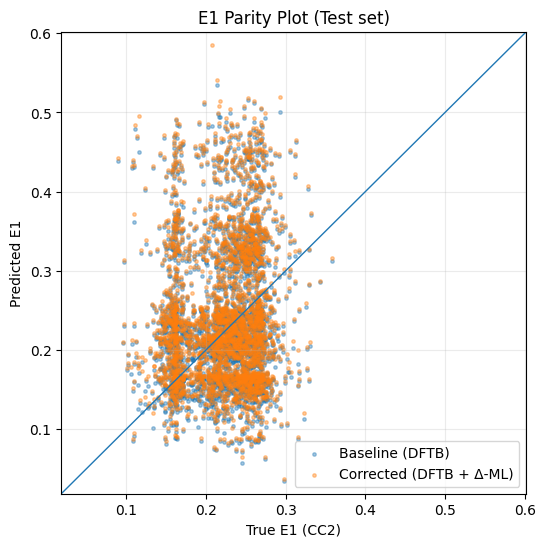

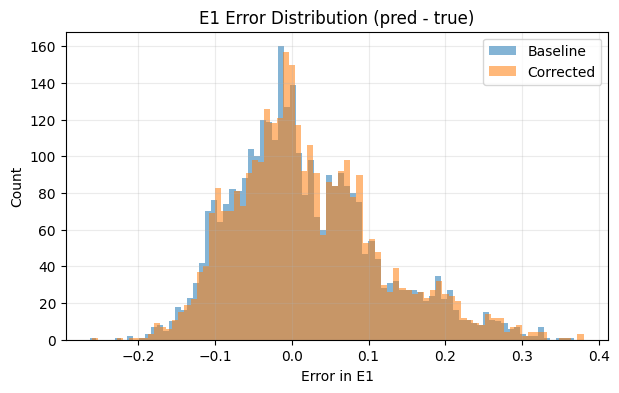

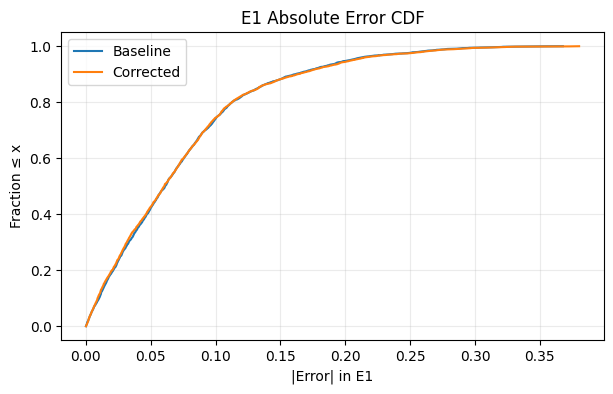

Baseline | P50=0.06110  P90=0.16139  P95=0.20284  P99=0.27831  Max=0.36775
Corrected | P50=0.06037  P90=0.16312  P95=0.20551  P99=0.28549  Max=0.38026


In [44]:
# ---- E1 (energy) plots ----
# True and predictions
y_true = E1_CC2_test
y_base = E1_DFTB_test
y_corr = E1_pred

# Parity plot
parity_plot(
    y_true, y_base, y_corr,
    label_a="Baseline (DFTB)",
    label_b="Corrected (DFTB + Δ-ML)",
    title="E1 Parity Plot (Test set)",
    xlabel="True E1 (CC2)",
    ylabel="Predicted E1"
)

# Error distributions
err_base = y_base - y_true
err_corr = y_corr - y_true
error_hist(
    err_base, err_corr,
    label_a="Baseline",
    label_b="Corrected",
    title="E1 Error Distribution (pred - true)",
    xlabel="Error in E1"
)

# Absolute error CDF
abs_base = np.abs(err_base)
abs_corr = np.abs(err_corr)
abs_error_cdf(
    abs_base, abs_corr,
    label_a="Baseline",
    label_b="Corrected",
    title="E1 Absolute Error CDF",
    xlabel="|Error| in E1"
)

# Optional: print percentiles on the plot-friendly numbers
for name, arr in [("Baseline", abs_base), ("Corrected", abs_corr)]:
    p50, p90, p95, p99 = np.percentile(arr, [50, 90, 95, 99])
    print(f"{name} | P50={p50:.5f}  P90={p90:.5f}  P95={p95:.5f}  P99={p99:.5f}  Max={arr.max():.5f}")

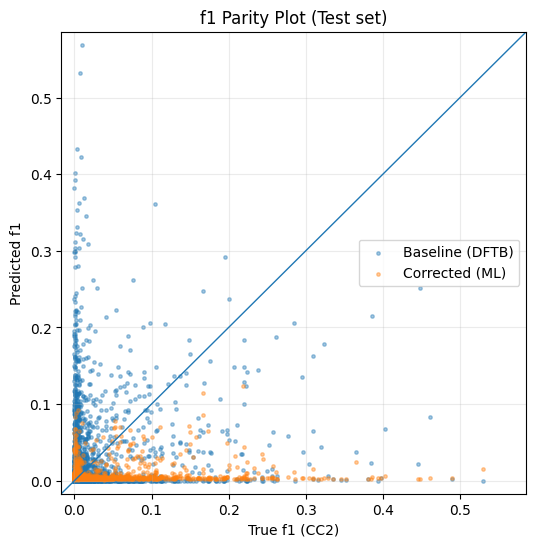

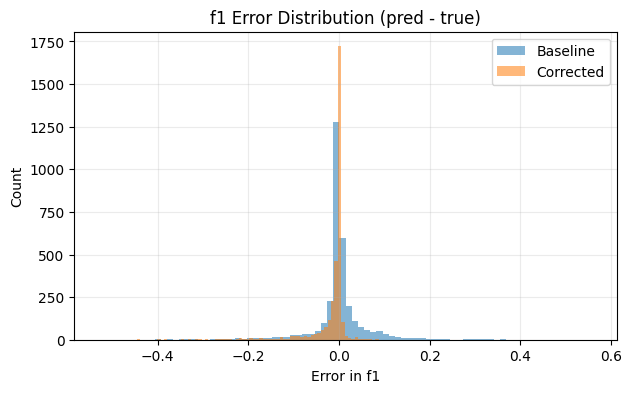

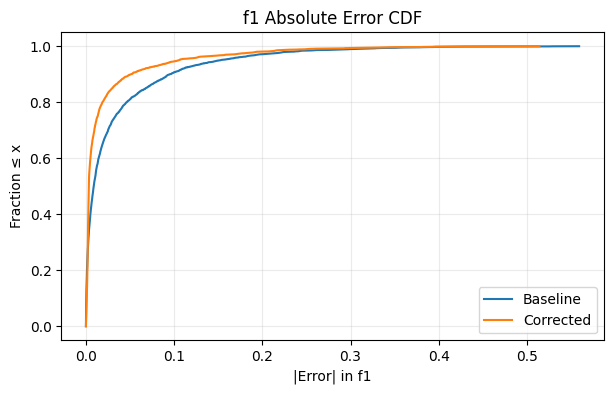

Baseline | P50=0.008850  P90=0.095205  P95=0.152542  P99=0.302438  Max=0.559110
Corrected | P50=0.003246  P90=0.051008  P95=0.105123  P99=0.252241  Max=0.514100


In [45]:
# ---- f1 plots ----
# Replace these with your variable names if different
f_true = f1_cc2[idx_test]      # true f1 (CC2)
f_base = f1_dftb[idx_test]     # baseline f1 (DFTB)

# Choose ONE of these depending on your approach:

# (A) Delta-learning:
# f_pred = f_base + df_pred

# (B) Direct learning:
# f_pred = model.predict(X_test_s, verbose=0).reshape(-1)

# Sanity:
assert f_true.shape == f_base.shape == f_pred.shape

parity_plot(
    f_true, f_base, f_pred,
    label_a="Baseline (DFTB)",
    label_b="Corrected (ML)",
    title="f1 Parity Plot (Test set)",
    xlabel="True f1 (CC2)",
    ylabel="Predicted f1",
)

err_base = f_base - f_true
err_corr = f_pred - f_true

error_hist(
    err_base, err_corr,
    label_a="Baseline",
    label_b="Corrected",
    title="f1 Error Distribution (pred - true)",
    xlabel="Error in f1"
)

abs_base = np.abs(err_base)
abs_corr = np.abs(err_corr)

abs_error_cdf(
    abs_base, abs_corr,
    label_a="Baseline",
    label_b="Corrected",
    title="f1 Absolute Error CDF",
    xlabel="|Error| in f1"
)

for name, arr in [("Baseline", abs_base), ("Corrected", abs_corr)]:
    p50, p90, p95, p99 = np.percentile(arr, [50, 90, 95, 99])
    print(f"{name} | P50={p50:.6f}  P90={p90:.6f}  P95={p95:.6f}  P99={p99:.6f}  Max={arr.max():.6f}")

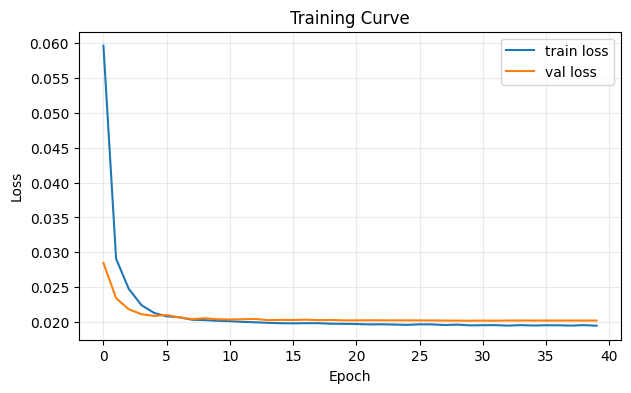

In [46]:
# Only works if you have `history` from model.fit(...)
plt.figure(figsize=(7,4))
plt.plot(history.history["loss"], label="train loss")
if "val_loss" in history.history:
    plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Curve")
plt.legend()
plt.grid(True, alpha=0.25)
plt.show()